## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l_ratio=1e-4, regulizer=l1):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regulizer(l_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regulizer(l_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
REGULIZER = [l1, l1_l2]

In [7]:
results = {}
"""
Set your training loop
"""
for regulizer in REGULIZER:
    for regulizer_ratio in L_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %s, Regulizer ratio = %.6f" % (str(regulizer), regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], l_ratio=regulizer_ratio, regulizer=regulizer)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-reg-%s-l2-%s" % (str(regulizer), str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with Regulizer = <function l1 at 0x000001B46A9461E0>, Regulizer ratio = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 1000

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 45us/step - loss: 6.0091 - acc: 0.2721 - val_loss: 5.8225 - val_acc: 0.3426
Epoch 2/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.7249 - acc: 0.3658 - val_loss: 5.6469 - val_acc: 0.3858
Epoch 3/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.5749 - acc: 0.3963 - val_loss: 5.5114 - val_acc: 0.4093
Epoch 4/50
50000/50000 [==============================] - 2s 38us/step - loss: 5.4529 - acc: 0.4169 - val_loss: 5.4037 - val_acc: 0.4222
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.3436 - acc: 0.4317 - val_loss: 5.3007 - val_acc: 0.4348
Epoch 6/50
50000/50000 [==============================] - 2s 38us/step - loss: 5.2422 - acc: 0.4455 - val_loss: 5.2296 - val_acc: 0.4394
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 5.1488 - acc: 0.4553 - val_loss: 5.1286 - val_acc

Epoch 2/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.8302 - acc: 0.3538 - val_loss: 1.7918 - val_acc: 0.3650
Epoch 3/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.7504 - acc: 0.3874 - val_loss: 1.7237 - val_acc: 0.3941
Epoch 4/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6867 - acc: 0.4096 - val_loss: 1.6712 - val_acc: 0.4044
Epoch 5/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6359 - acc: 0.4250 - val_loss: 1.6191 - val_acc: 0.4283
Epoch 6/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5942 - acc: 0.4396 - val_loss: 1.5925 - val_acc: 0.4425
Epoch 7/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5590 - acc: 0.4524 - val_loss: 1.5586 - val_acc: 0.4521
Epoch 8/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5273 - acc: 0.4658 - val_loss: 1.5401 - val_acc: 0.4539
Epoch 9/50
50000/50000 [=================

50000/50000 [==============================] - 2s 39us/step - loss: 1.7120 - acc: 0.4009 - val_loss: 1.6839 - val_acc: 0.4093
Epoch 4/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6569 - acc: 0.4228 - val_loss: 1.6400 - val_acc: 0.4186
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6100 - acc: 0.4370 - val_loss: 1.6106 - val_acc: 0.4292
Epoch 6/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5736 - acc: 0.4518 - val_loss: 1.5690 - val_acc: 0.4457
Epoch 7/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5386 - acc: 0.4602 - val_loss: 1.5364 - val_acc: 0.4555
Epoch 8/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5116 - acc: 0.4702 - val_loss: 1.5380 - val_acc: 0.4542
Epoch 9/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.4835 - acc: 0.4806 - val_loss: 1.5035 - val_acc: 0.4642
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 39us/step - loss: 2.4631 - acc: 0.0998 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4624 - acc: 0.0972 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4624 - acc: 0.0963 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4624 - acc: 0.0988 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4623 - acc: 0.0975 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4623 - acc: 0.0982 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4622 - acc: 0.0990 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 39us/step - loss: 10.5307 - acc: 0.4032 - val_loss: 9.8266 - val_acc: 0.4066
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 9.1955 - acc: 0.4078 - val_loss: 8.5922 - val_acc: 0.4138
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 8.0575 - acc: 0.4125 - val_loss: 7.5458 - val_acc: 0.4174
Epoch 8/50
50000/50000 [==============================] - 2s 39us/step - loss: 7.0874 - acc: 0.4194 - val_loss: 6.6488 - val_acc: 0.4215
Epoch 9/50
50000/50000 [==============================] - 2s 39us/step - loss: 6.2613 - acc: 0.4227 - val_loss: 5.8925 - val_acc: 0.4251
Epoch 10/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.5579 - acc: 0.4263 - val_loss: 5.2497 - val_acc: 0.4256
Epoch 11/50
50000/50000 [==============================] - 2s 39us/step - loss: 4.9597 - acc: 0.4296 - val_loss: 4.6920 - val_acc: 0.4332
Epoch 12/50
50000/50000 [========================

50000/50000 [==============================] - 2s 39us/step - loss: 7.7058 - acc: 0.4097 - val_loss: 7.2413 - val_acc: 0.4142
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 6.8351 - acc: 0.4168 - val_loss: 6.4417 - val_acc: 0.4209
Epoch 8/50
50000/50000 [==============================] - 2s 39us/step - loss: 6.0923 - acc: 0.4217 - val_loss: 5.7587 - val_acc: 0.4227
Epoch 9/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.4577 - acc: 0.4272 - val_loss: 5.1770 - val_acc: 0.4252
Epoch 10/50
50000/50000 [==============================] - 2s 39us/step - loss: 4.9163 - acc: 0.4333 - val_loss: 4.6718 - val_acc: 0.4373
Epoch 11/50
50000/50000 [==============================] - 2s 38us/step - loss: 4.4530 - acc: 0.4356 - val_loss: 4.2519 - val_acc: 0.4366
Epoch 12/50
50000/50000 [==============================] - 2s 39us/step - loss: 4.0567 - acc: 0.4399 - val_loss: 3.8945 - val_acc: 0.4346
Epoch 13/50
50000/50000 [========================

50000/50000 [==============================] - 2s 39us/step - loss: 6.8272 - acc: 0.4258 - val_loss: 6.4303 - val_acc: 0.4268
Epoch 8/50
50000/50000 [==============================] - 2s 39us/step - loss: 6.0871 - acc: 0.4281 - val_loss: 5.7655 - val_acc: 0.4218
Epoch 9/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.4531 - acc: 0.4336 - val_loss: 5.1651 - val_acc: 0.4352
Epoch 10/50
50000/50000 [==============================] - 2s 39us/step - loss: 4.9119 - acc: 0.4372 - val_loss: 4.6689 - val_acc: 0.4377
Epoch 11/50
50000/50000 [==============================] - 2s 39us/step - loss: 4.4480 - acc: 0.4415 - val_loss: 4.2413 - val_acc: 0.4413
Epoch 12/50
50000/50000 [==============================] - 2s 40us/step - loss: 4.0529 - acc: 0.4428 - val_loss: 3.8833 - val_acc: 0.4385
Epoch 13/50
50000/50000 [==============================] - 2s 39us/step - loss: 3.7135 - acc: 0.4475 - val_loss: 3.5698 - val_acc: 0.4399
Epoch 14/50
50000/50000 [=======================

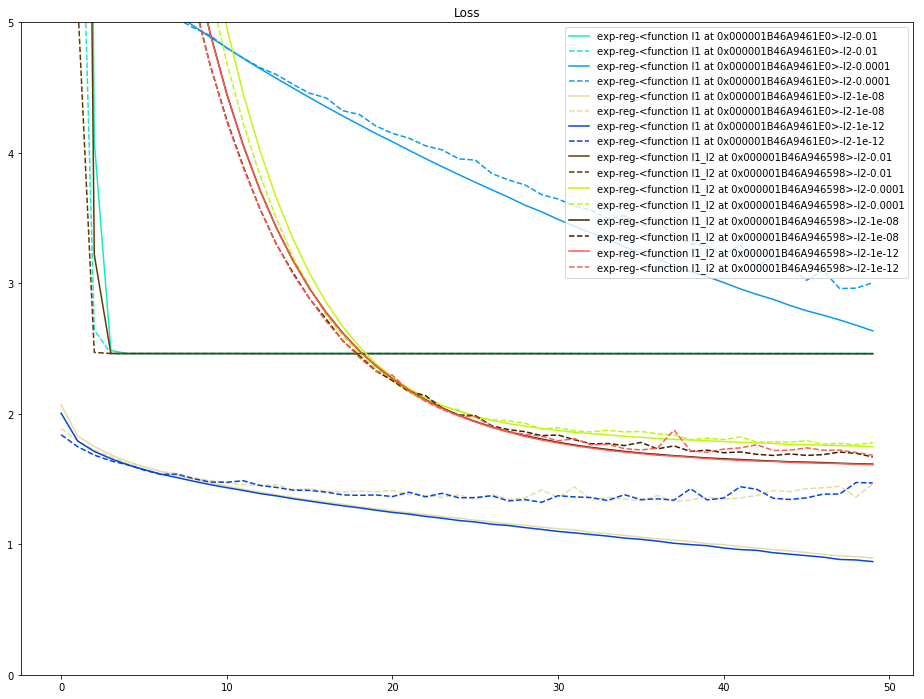

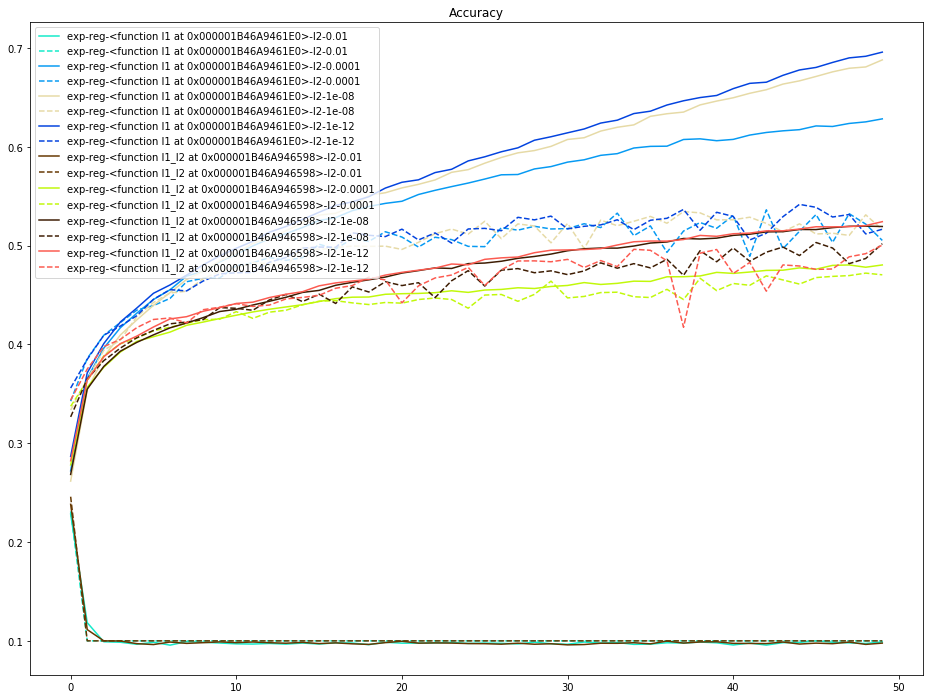

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
#color_bar = ["r", "g", "b", "y", "m", "k"]
color_bar = ["xkcd:aqua", "xkcd:azure", "xkcd:beige", "xkcd:blue", "xkcd:brown", "xkcd:chartreuse", 
             "xkcd:chocolate", "xkcd:coral", "xkcd:crimson", "xkcd:cyan", "xkcd:darkblue", "xkcd:darkgreen", 
             "xkcd:fuchsia", "xkcd:gold", "xkcd:green", "xkcd:gray", "xkcd:indigo", "xkcd:ivory", 
             "xkcd:khaki", "xkcd:lavender", "xkcd:lightblue", "xkcd:lightgreen", "xkcd:lime", "xkcd:orange"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()